In [1]:
import json
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

SAVE_PLOTS = False

# image save path
image_save_path = 'plots'

In [28]:
# load the predictions
# student
with open('../out/bert_student/m5_k10/shen_2_lr0.0002_e4/results/results.json', 'r') as f:
    student_mc_results = json.load(f)
    
# augmented student
# prs0.1: shen=2, lr=0.0002, e=2
# prs0.1, psr0.1: shen=0.5, lr=0.000002, e=3
# prs0.05, psr0.05: shen=0.5, lr=0.000002, e=2; shen=1, lr=0.0002, e=2
with open('../out/bert_student_augmented/m5_k10/archived_prs0.1/shen_2_lr0.0002_e2_augmented/results/results.json', 'r') as f:
    student_augmented_mc_results = json.load(f)

In [29]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["font.family"] = "serif"

In [30]:
# predictive performance

# f1
print(f"Student F1: {student_mc_results['f1_score']:.4f}")
print(f"Augmented Student F1: {student_augmented_mc_results['f1_score']:.4f}")

# auc
print(f"Student AUC: {student_mc_results['auc_score']:.4f}")
print(f"Augmented Student AUC: {student_augmented_mc_results['auc_score']:.4f}")

Student F1: 0.9807
Augmented Student F1: 0.9820
Student AUC: 0.9915
Augmented Student AUC: 0.9916


In [31]:
# uncertainty performance

# ece
print(f"Student ECE: {student_mc_results['ece_score_l1']:.4f}")
print(f"Augmented Student ECE: {student_augmented_mc_results['ece_score_l1']:.4f}")

# brier
print(f"Student Brier: {student_mc_results['brier_score']:.4f}")
print(f"Augmented Student Brier: {student_augmented_mc_results['brier_score']:.4f}")

Student ECE: 0.0217
Augmented Student ECE: 0.0177
Student Brier: 0.0249
Augmented Student Brier: 0.0240


In [32]:
student_results = {
    'f1': student_mc_results['f1_score'],
    'auc': student_mc_results['auc_score'],
    'ece': student_mc_results['ece_score_l1'],
    'brier': student_mc_results['brier_score']
}

student_augmented_results = {
    'f1': student_augmented_mc_results['f1_score'],
    'auc': student_augmented_mc_results['auc_score'],
    'ece': student_augmented_mc_results['ece_score_l1'],
    'brier': student_augmented_mc_results['brier_score']
}

results_df = pd.DataFrame([student_results, student_augmented_results], index=['Student', 'Augmented Student'])

In [33]:
# round all values to 3 decimal places
print(results_df.to_latex(index=True, float_format="{:.3f}".format))

\begin{tabular}{lrrrr}
\toprule
 & f1 & auc & ece & brier \\
\midrule
Student & 0.981 & 0.992 & 0.022 & 0.025 \\
Augmented Student & 0.982 & 0.992 & 0.018 & 0.024 \\
\bottomrule
\end{tabular}


In [34]:
print("Student avg. BALD score: ", np.mean(student_mc_results['bald_score']))
print("Augmented Student avg. BALD score: ", np.mean(student_augmented_mc_results['bald_score']))

Student avg. BALD score:  0.006128525281914432
Augmented Student avg. BALD score:  0.006784983642710002


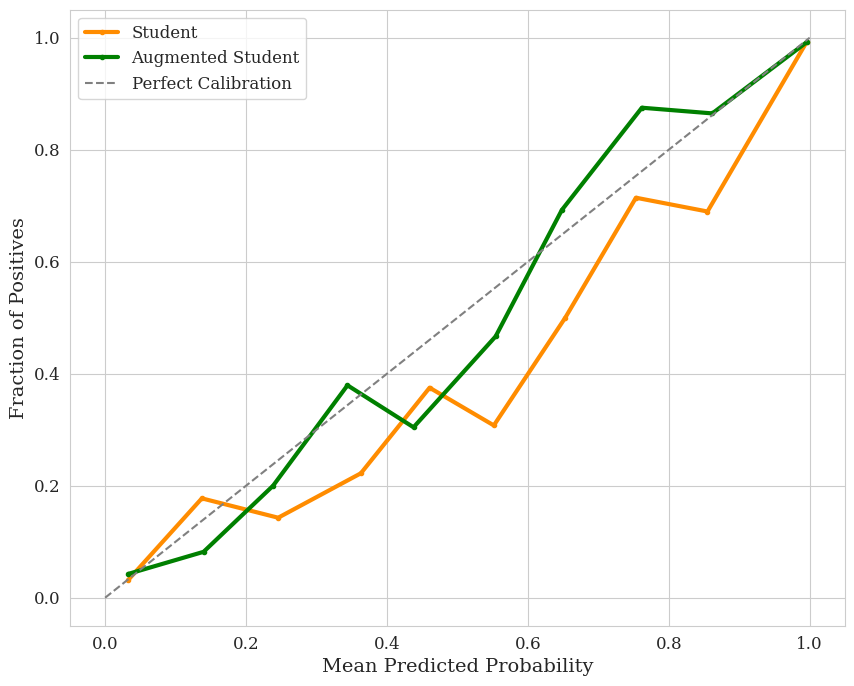

In [35]:
# calibration plot
from sklearn.calibration import calibration_curve

with open(f'../out/bert_teacher/final_e3_lr2_hd020_ad020_cd030/results/results.json', 'r') as f:
        teacher_results = json.load(f) # these are actually the results from the MCD model!

plt.figure(figsize=(10, 8))

# student
fop, mpv = calibration_curve(y_true=student_mc_results['y_true'], y_prob=student_mc_results['y_prob'], n_bins=10)
plt.plot(mpv, fop, marker='.', lw=3, label='Student', color='darkorange')
# augmented student
fop, mpv = calibration_curve(y_true=student_augmented_mc_results['y_true'], y_prob=student_augmented_mc_results['y_prob'], n_bins=10)
plt.plot(mpv, fop, marker='.', lw=3, label='Augmented Student', color='green')

plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Perfect Calibration')

plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
# plt.title('Model Calibration')
plt.legend()
if SAVE_PLOTS:
    plt.tight_layout()
    plt.savefig(os.path.join(image_save_path, f"plot_calibration_plot_student_augmented_student.pdf"))
    plt.close()

In [36]:
# f1 score
teacher_results['f1_score'], student_mc_results['f1_score'], student_augmented_mc_results['f1_score']
# augmented student > student > teacher

(0.9799758745476479, 0.9806576402321083, 0.9820213799805636)

In [37]:
# brier score
teacher_results['brier_score'], student_mc_results['brier_score'], student_augmented_mc_results['brier_score']
# augmented student > teacher > student

(0.02421403987034935, 0.024903782388658317, 0.02403716299954644)

In [38]:
# ece score
teacher_results['ece_score_l1'], student_mc_results['ece_score_l1'], student_augmented_mc_results['ece_score_l1']
# augmented student > student > teacher

(0.022472769021987915, 0.02171805314719677, 0.017707474529743195)

In [39]:
# entropy
from scipy.stats import entropy

teacher_entropy = np.mean([entropy([p, 1-p])  for p in teacher_results['y_prob']])
student_entropy = np.mean([entropy([p, 1-p])  for p in student_mc_results['y_prob']])
student_augmented_entropy = np.mean([entropy([p, 1-p])  for p in student_augmented_mc_results['y_prob']])

teacher_entropy, student_entropy, student_augmented_entropy # the higher, the more uncertain (flatter distribution)
# augmented student > student > teacher 

# corresponds to high-entropy posterior distribution

(0.07662550488332917, 0.07719258805670362, 0.07883733879906366)

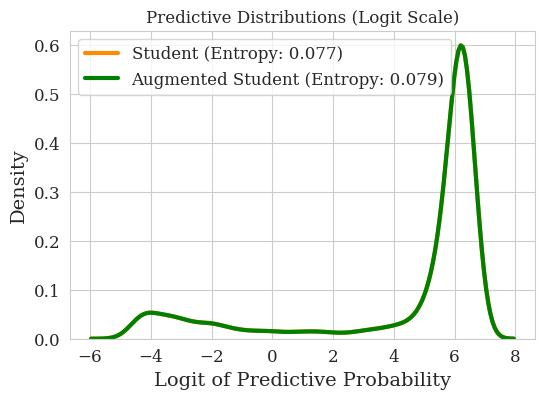

In [40]:
# similarity of predictive distributions - cdf plot
from scipy.special import logit
import seaborn as sns

# Transforming data using logit function to better visualize skewed data
student_logit_dist = logit(np.array(student_mc_results['y_prob']))
augmented_student_logit_dist = logit(np.array(student_augmented_mc_results['y_prob']))

plt.figure(figsize=(6, 4))
sns.kdeplot(student_logit_dist, bw_adjust=0.5, lw=3, label=f'Student (Entropy: {student_entropy:.3f})', color='darkorange')
sns.kdeplot(student_logit_dist, bw_adjust=0.5, lw=3, label=f'Augmented Student (Entropy: {student_augmented_entropy:.3f})', color='green')
#sns.kdeplot(logit_dist3, bw_adjust=0.5, label='Distribution 3')
plt.xlabel('Logit of Predictive Probability')
plt.ylabel('Density')
plt.title('Predictive Distributions (Logit Scale)')
plt.legend()
plt.grid(True)
if SAVE_PLOTS:
    plt.tight_layout()
    plt.savefig(os.path.join(image_save_path, f"plot_density_logit_student_augmented_student.pdf"))
    plt.close()

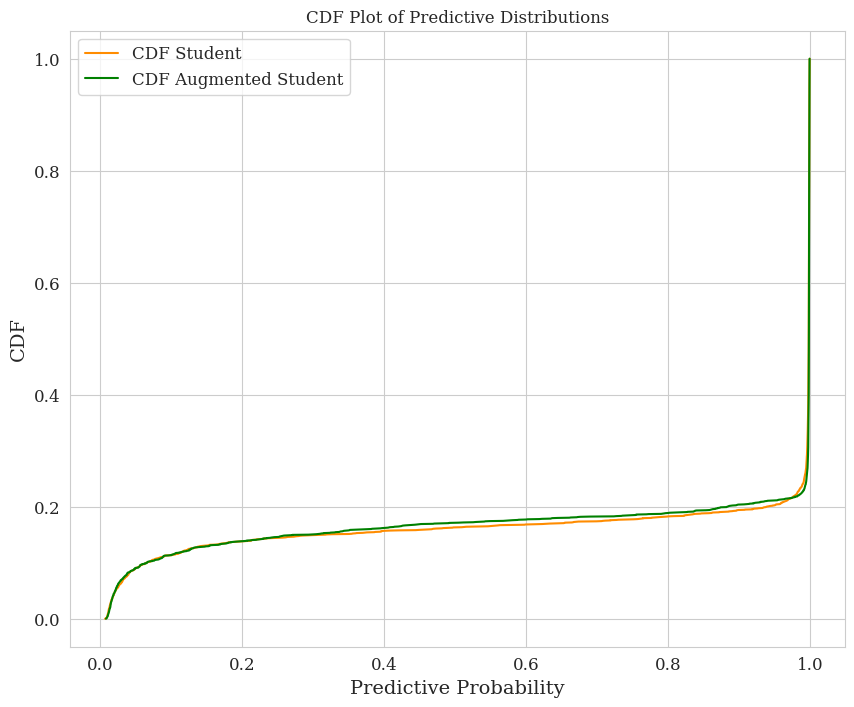

In [41]:
def calculate_cdf(data):
    # Sort data
    data_sorted = np.sort(data)
    # Calculate CDF values
    cdf = np.arange(1, len(data) + 1) / len(data)
    return data_sorted, cdf

# Calculate CDF for each distribution
data_sorted2, cdf2 = calculate_cdf(np.array(student_mc_results['y_prob']))
data_sorted3, cdf3 = calculate_cdf(np.array(student_augmented_mc_results['y_prob']))

plt.figure(figsize=(10, 8))
plt.plot(data_sorted2, cdf2, label='CDF Student', color='darkorange')
plt.plot(data_sorted3, cdf3, label='CDF Augmented Student', color='green')
plt.xlabel('Predictive Probability')
plt.ylabel('CDF')
plt.title('CDF Plot of Predictive Distributions')
plt.legend()
plt.grid(True)
plt.show()

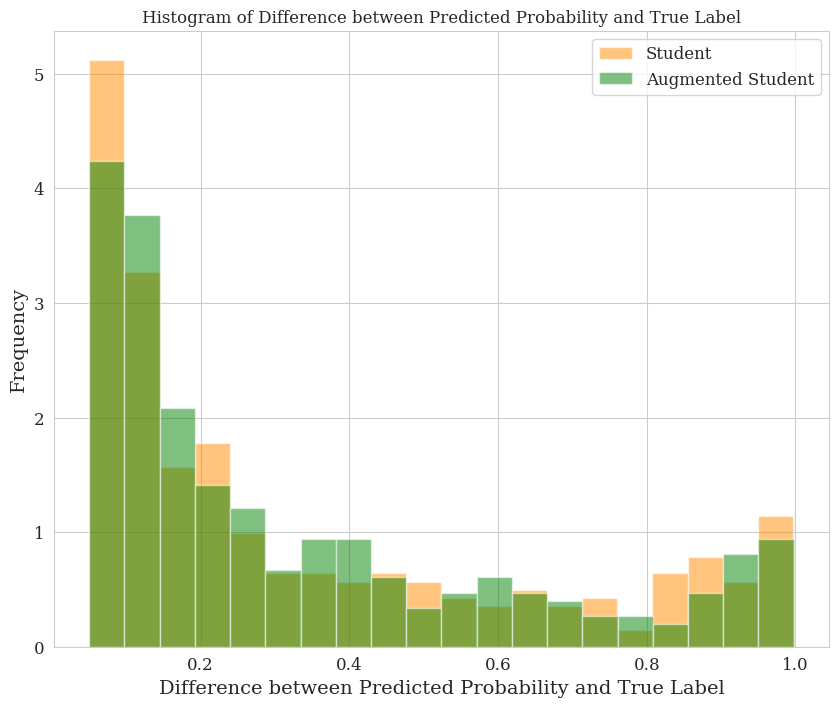

In [42]:
# histogram of difference between predicted probability and true label
plt.figure(figsize=(10, 8))
# need to turn lists in np arrays   
student_mc_results['y_true'] = np.array(student_mc_results['y_true'])
student_mc_results['y_prob'] = np.array(student_mc_results['y_prob'])
student_augmented_mc_results['y_true'] = np.array(student_augmented_mc_results['y_true'])
student_augmented_mc_results['y_prob'] = np.array(student_augmented_mc_results['y_prob'])

diff_student = np.abs(student_mc_results['y_true'] - student_mc_results['y_prob'])
diff_augmented_student = np.abs(student_augmented_mc_results['y_true'] - student_augmented_mc_results['y_prob'])

cropped_diff_student = diff_student[diff_student > 0.05]
cropped_diff_augmented_student = diff_augmented_student[diff_augmented_student > 0.05]

plt.hist(diff_student[diff_student > 0.05], bins=20, alpha=0.5, label='Student', density=True, color='darkorange')
plt.hist(diff_augmented_student[diff_augmented_student > 0.05], bins=20, alpha=0.5, label='Augmented Student', density=True, color='green')
plt.xlabel('Difference between Predicted Probability and True Label')
plt.ylabel('Frequency')
plt.title('Histogram of Difference between Predicted Probability and True Label')
plt.legend();

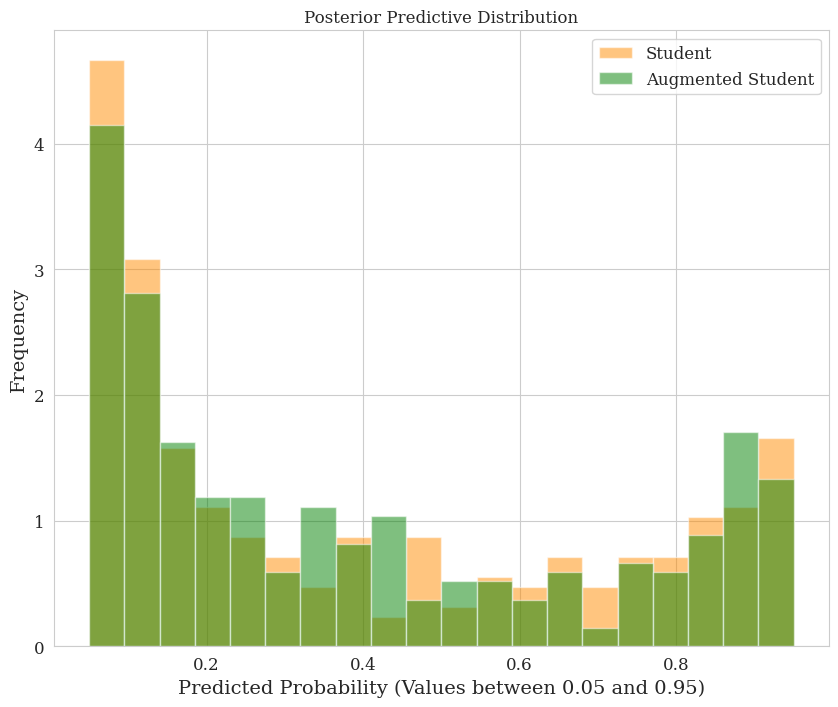

In [43]:
# clipped histogram between 0.05 and 0.95 of student and augmented student prob.
plt.figure(figsize=(10, 8))

prob_student = student_mc_results['y_prob']
prob_augmented_student = student_augmented_mc_results['y_prob']

plt.hist(prob_student, bins=20, alpha=0.5, label='Student', density=True, color='darkorange', range=(0.05, 0.95))
plt.hist(prob_augmented_student, bins=20, alpha=0.5, label='Augmented Student', density=True, color='green', range=(0.05, 0.95))
plt.xlabel('Predicted Probability (Values between 0.05 and 0.95)')
plt.ylabel('Frequency')
plt.title('Posterior Predictive Distribution')
plt.legend();

In [44]:
# augmented student has softer distribution -> fewer extremes, more towards 0.5 (especially for low values)